## Import Semua Packages/Library yang Digunakan

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import mixed_precision
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Preparation

### Data Loading

In [3]:
# Konfigurasi direktori
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, 'garbage-dataset')

# Direktori output
OUTPUT_DIR = BASE_DIR
MODEL_DIR = os.path.join(OUTPUT_DIR, 'saved_model')
TFLITE_DIR = os.path.join(OUTPUT_DIR, 'tflite')
TFJS_DIR = os.path.join(OUTPUT_DIR, 'tfjs_model')
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')

for directory in [MODEL_DIR, TFLITE_DIR, TFJS_DIR, PLOTS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Hyperparameter
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 0.001

# Nama kelas
CLASS_NAMES = ['battery', 'biological', 'cardboard', 'clothes', 'glass',
               'metal', 'paper', 'plastic', 'shoes', 'trash']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Dataset Path: {DATASET_PATH}")
print(f"Jumlah Kelas: {NUM_CLASSES}")
print(f"Ukuran Gambar: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")

Dataset Path: d:\Dicoding\Deep learning\Garbage classification\garbage-dataset
Jumlah Kelas: 10
Ukuran Gambar: (224, 224)
Batch Size: 32
Max Epochs: 40


In [4]:
# jumlah gambar per kelas
def count_images(dataset_path, class_names):
    class_counts = {}
    total = 0
    
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))])
            class_counts[class_name] = count
            total += count
    
    return class_counts, total

class_distribution, total_images = count_images(DATASET_PATH, CLASS_NAMES)

# Tampilkan distribusi
print("\nDistribusi Dataset:")
for class_name, count in sorted(class_distribution.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_images) * 100
    print(f"{class_name:15s}: {count:5d} gambar ({percentage:.2f}%)")
print(f"{'TOTAL':15s}: {total_images:5d} gambar")


Distribusi Dataset:
clothes        :  5327 gambar (26.96%)
glass          :  3061 gambar (15.49%)
plastic        :  1984 gambar (10.04%)
shoes          :  1977 gambar (10.00%)
cardboard      :  1825 gambar (9.23%)
paper          :  1680 gambar (8.50%)
metal          :  1020 gambar (5.16%)
biological     :   997 gambar (5.05%)
trash          :   947 gambar (4.79%)
battery        :   944 gambar (4.78%)
TOTAL          : 19762 gambar


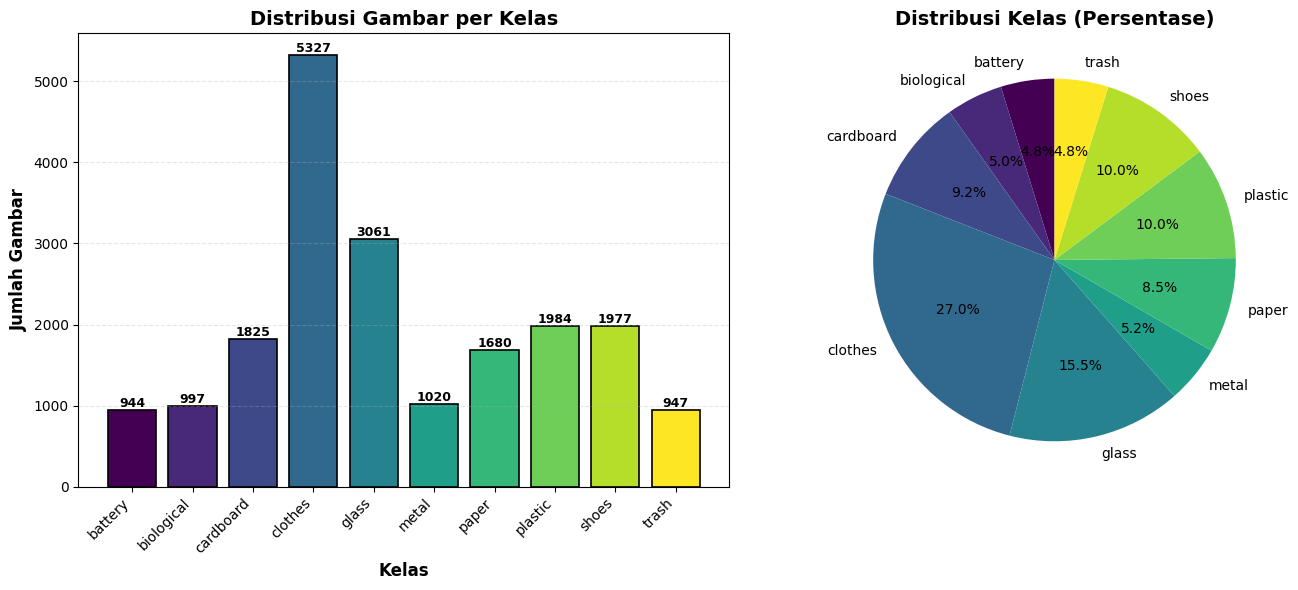

In [ ]:
# Visualisasi distribusi kelas
plt.figure(figsize=(14, 6))

# Bar chart
plt.subplot(1, 2, 1)
classes = list(class_distribution.keys())
counts = list(class_distribution.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))

bars = plt.bar(classes, counts, color=colors, edgecolor='black', linewidth=1.2)
plt.xlabel('Kelas', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Gambar', fontsize=12, fontweight='bold')
plt.title('Distribusi Gambar per Kelas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan label nilai
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribusi Kelas (Persentase)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'class_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Analisis resolusi gambar
print("Menganalisis resolusi gambar")

resolutions = []
sample_size = 150

for class_name in CLASS_NAMES[:3]:
    class_path = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))][:sample_size//3]
    
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path)
            resolutions.append(img.size)
        except:
            continue

unique_resolutions = set(resolutions)
print(f"\nJumlah resolusi unik ditemukan: {len(unique_resolutions)}")
print(f"Contoh resolusi: {list(unique_resolutions)[:10]}")


Menganalisis resolusi gambar

Jumlah resolusi unik ditemukan: 71
Contoh resolusi: [(260, 194), (298, 297), (708, 708), (224, 300), (264, 191), (265, 190), (180, 180), (474, 370), (151, 232), (800, 800)]


Menampilkan contoh gambar dari setiap kelas...


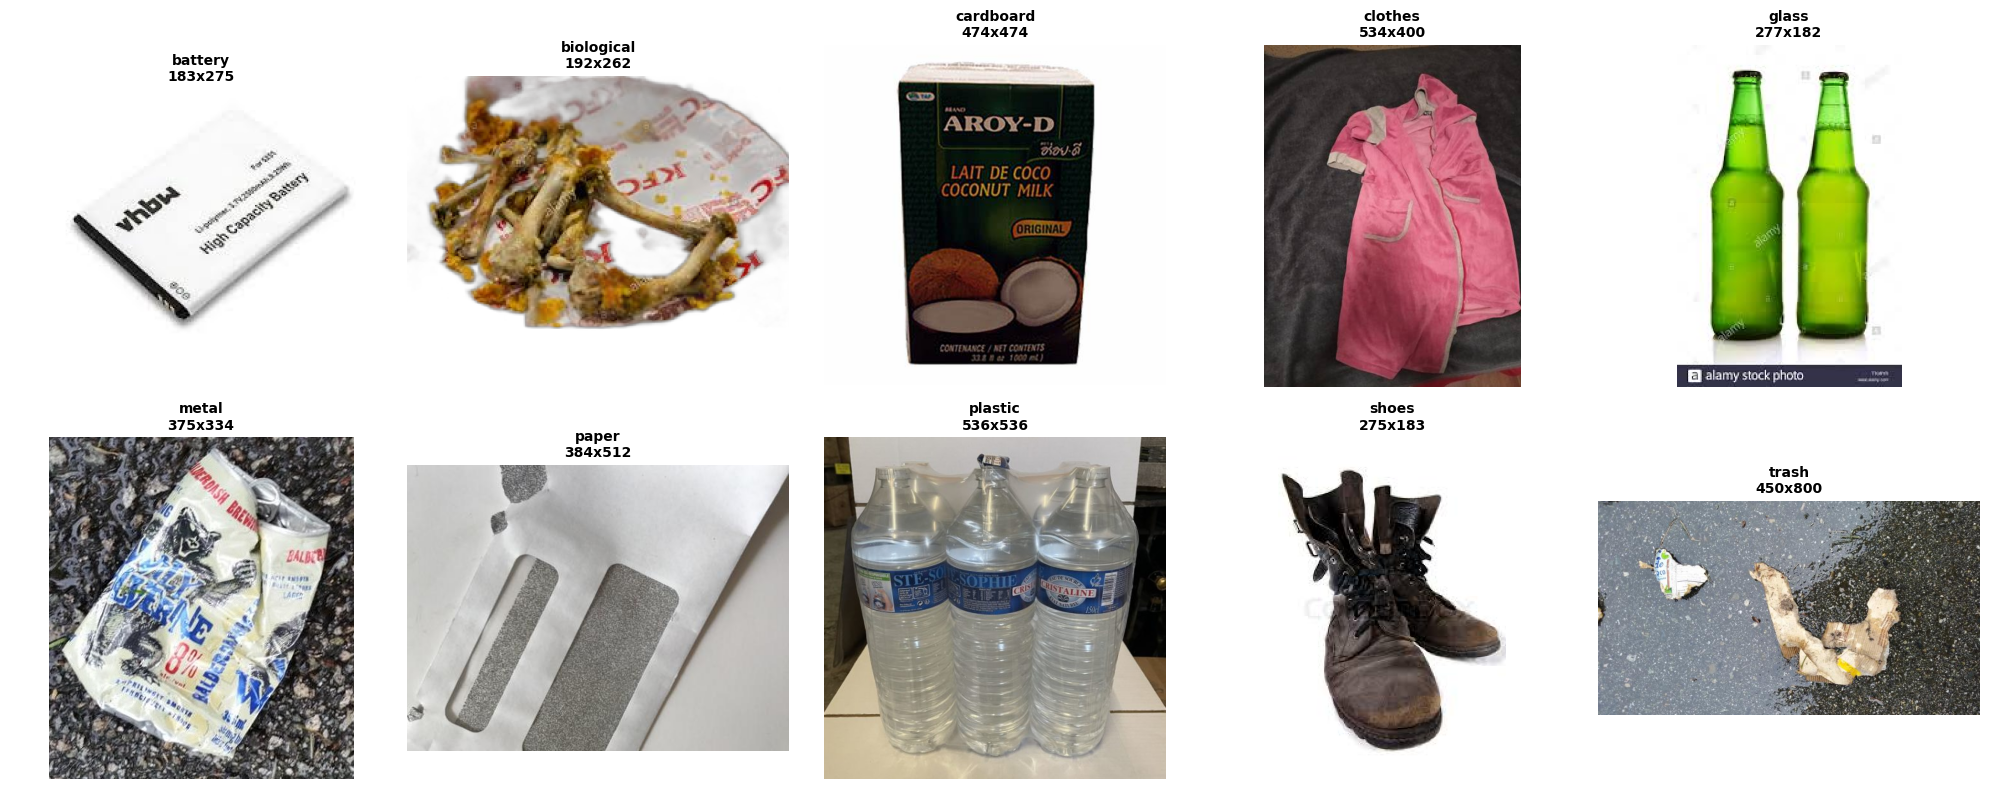

In [ ]:
# Tampilkan sample gambar dari setiap kelas
print("Menampilkan contoh gambar dari setiap kelas...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    if images:
        sample_img = images[0]
        img_path = os.path.join(class_path, sample_img)
        try:
            img = plt.imread(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'{class_name}\n{img.shape[0]}x{img.shape[1]}', 
                              fontsize=10, fontweight='bold')
            axes[idx].axis('off')
        except:
            axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Fungsi validasi gambar
def is_valid_image(file_path):
    try:
        # Cek file ada dan tidak kosong
        if not os.path.exists(file_path):
            return False, "File tidak ditemukan"
        
        if os.path.getsize(file_path) == 0:
            return False, "File kosong"
        
        # Validasi dengan PIL
        from PIL import Image
        img = Image.open(file_path)
        img.verify()
        img = Image.open(file_path)

        # Cek dimensi
        width, height = img.size
        if width < 10 or height < 10:
            return False, "Gambar terlalu kecil"
        
        # Cek format
        if img.format not in ['JPEG', 'PNG', 'BMP', 'GIF']:
            return False, f"Format tidak didukung: {img.format}"
        
        return True, "Valid"
    except Exception as e:
        return False, str(e)

# Load dan validasi semua gambar
print("Memvalidasi semua gambar")

image_paths = []
labels = []
skipped_files = []
skipped_reasons = {}

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    all_files = [f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    valid_count = 0
    invalid_count = 0
    
    for img_name in all_files:
        img_path = os.path.join(class_path, img_name)
        is_valid, reason = is_valid_image(img_path)
        
        if is_valid:
            image_paths.append(img_path)
            labels.append(class_idx)
            valid_count += 1
        else:
            skipped_files.append(img_path)
            skipped_reasons[reason] = skipped_reasons.get(reason, 0) + 1
            invalid_count += 1
    
    print(f"{class_name:15s}: {valid_count:5d} valid, {invalid_count:3d} skip")

# Konversi ke numpy array
image_paths = np.array(image_paths)
labels = np.array(labels)

# Ringkasan validasi
print("RINGKASAN VALIDASI GAMBAR")
print(f" Gambar valid:     {len(image_paths):,}")
print(f"  File di-skip:     {len(skipped_files):,}")

if skipped_files:
    print(f"\nAlasan skip:")
    for reason, count in sorted(skipped_reasons.items(), key=lambda x: x[1], reverse=True):
        print(f"   - {reason}: {count} file")

Memvalidasi semua gambar
battery        :   944 valid,   0 skip
biological     :   997 valid,   0 skip
cardboard      :  1825 valid,   0 skip
clothes        :  5327 valid,   0 skip
glass          :  3060 valid,   1 skip
metal          :  1020 valid,   0 skip
paper          :  1675 valid,   5 skip
plastic        :  1981 valid,   3 skip
shoes          :  1977 valid,   0 skip
trash          :   947 valid,   0 skip
RINGKASAN VALIDASI GAMBAR
 Gambar valid:     19,753
  File di-skip:     9

Alasan skip:
   - Format tidak didukung: MPO: 6 file
   - Format tidak didukung: WEBP: 3 file


### Data Preprocessing

#### Split Dataset

In [9]:
# Split 70-30 untuk train dan temp
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.30, random_state=SEED, stratify=labels
)

# Split temp 50-50 untuk validation dan test (masing-masing 15%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=SEED, stratify=temp_labels
)

In [10]:
# Hitung class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("\nClass Weights:")
for class_idx, weight in class_weights.items():
    print(f"  {CLASS_NAMES[class_idx]:15s}: {weight:.4f}")


Class Weights:
  battery        : 2.0918
  biological     : 1.9809
  cardboard      : 1.0828
  clothes        : 0.3708
  glass          : 0.6455
  metal          : 1.9366
  paper          : 1.1798
  plastic        : 0.9969
  shoes          : 0.9991
  trash          : 2.0855


In [11]:
# TensorFlow Dataset
def create_tf_dataset(paths, labels, augmentation=False, batch_size=BATCH_SIZE):

    def load_and_preprocess(path, label):
        # Load gambar
        img = tf.io.read_file(path)
        
        # Decode gambar
        try:
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
        except:
            # Fallback
            img = tf.zeros([224, 224, 3], dtype=tf.uint8)
        
        # Set shape 
        img.set_shape([None, None, 3])
        
        # Resize dan normalisasi
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0

        # Data augmentation 
        if augmentation:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)

        # Konversi label ke one-hot
        label = tf.one_hot(label, NUM_CLASSES)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(
        load_and_preprocess, 
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False 
    )

    if augmentation:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.cache() 
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Buat datasets
train_dataset = create_tf_dataset(train_paths, train_labels, augmentation=True)
val_dataset = create_tf_dataset(val_paths, val_labels, augmentation=False)
test_dataset = create_tf_dataset(test_paths, test_labels, augmentation=False)

## Modelling

In [12]:
# Load pre-trained MobileNetV2

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model 
base_model.trainable = False

print(f"Base Model: MobileNetV2")
print(f"  - Input Shape: {IMG_SIZE + (3,)}")
print(f"  - Trainable: {base_model.trainable}")
print(f"  - Total Parameters: {base_model.count_params():,}")

# Bangun Sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='input_layer'),
    base_model,
    tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        name='custom_conv2d_1'
    ),
    tf.keras.layers.BatchNormalization(name='batch_norm_1'),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        name='maxpool_1'
    ),
    tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        name='custom_conv2d_2'
    ),
    tf.keras.layers.BatchNormalization(name='batch_norm_2'),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        name='maxpool_2'
    ),
    tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool'),
    tf.keras.layers.Dense(256, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.5, name='dropout_1'),
    tf.keras.layers.Dense(128, activation='relu', name='dense_2'),
    tf.keras.layers.Dropout(0.3, name='dropout_2'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')
    
], name='garbage_classifier')

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)



print(f"\nTotal Parameters: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable Parameters: {trainable_params:,}")



Base Model: MobileNetV2
  - Input Shape: (224, 224, 3)
  - Trainable: False
  - Total Parameters: 2,257,984

Total Parameters: 5,571,146
Trainable Parameters: 3,312,394


In [13]:
# Setup callbacks

checkpoint_path = os.path.join(MODEL_DIR, 'best_model.keras')

callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [14]:
# Training
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}\n")

# Train model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Steps per epoch: 432
Validation steps: 92

Epoch 1/40


433/433 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.8021 - precision: 0.8823 - recall: 0.7478
Epoch 1: val_accuracy improved from -inf to 0.89065, saving model to d:\Dicoding\Deep learning\Garbage classification\saved_model\best_model.keras
433/433 [==============================] - 238s 538ms/step - loss: 0.7015 - accuracy: 0.8021 - precision: 0.8823 - recall: 0.7478 - val_loss: 0.3602 - val_accuracy: 0.8907 - val_precision: 0.9198 - val_recall: 0.8667 - lr: 0.0010
Epoch 2/40
433/433 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.9024 - precision: 0.9261 - recall: 0.8806
Epoch 2: val_accuracy improved from 0.89065 to 0.90483, saving model to d:\Dicoding\Deep learning\Garbage classification\saved_model\best_model.keras
433/433 [==============================] - 223s 514ms/step - loss: 0.3406 - accuracy: 0.9024 - precision: 0.9261 - recall: 0.8806 - val_loss: 0.3254 - val_accurac

## Evaluasi dan Visualisasi

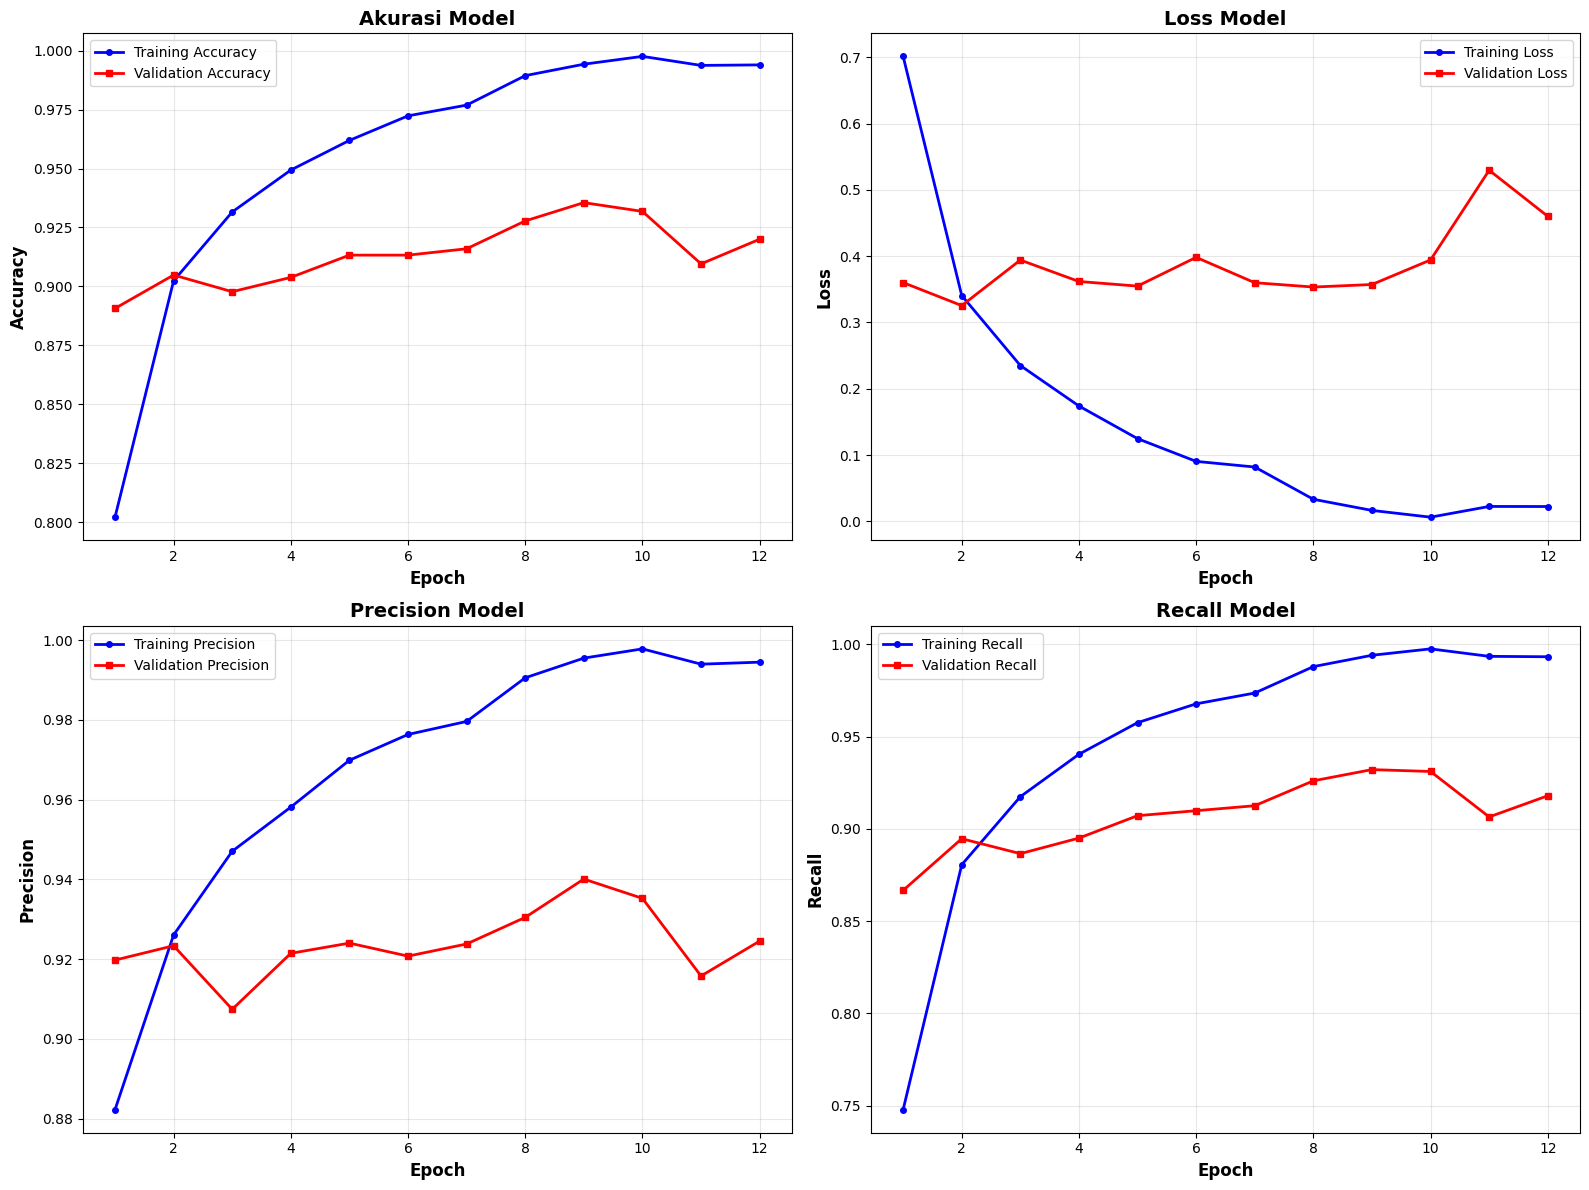

In [ ]:
# Visualisasi training history

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'loss', 'precision', 'recall']
titles = ['Akurasi Model', 'Loss Model', 'Precision Model', 'Recall Model']
ylabels = ['Accuracy', 'Loss', 'Precision', 'Recall']

for idx, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
    ax = axes[idx // 2, idx % 2]
    
    train_values = history.history[metric]
    val_values = history.history[f'val_{metric}']
    epochs_range = range(1, len(train_values) + 1)
    
    ax.plot(epochs_range, train_values, 'b-o', label=f'Training {ylabel}', linewidth=2, markersize=4)
    ax.plot(epochs_range, val_values, 'r-s', label=f'Validation {ylabel}', linewidth=2, markersize=4)
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Evaluasi model pada test set

test_results = model.evaluate(test_dataset, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_accuracy*100:.2f}%")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print("="*60)

93/93 [==============================] - 43s 462ms/step - loss: 0.3203 - accuracy: 0.9092 - precision: 0.9271 - recall: 0.8930
Loss:      0.3203
Accuracy:  90.92%
Precision: 0.9271
Recall:    0.8930


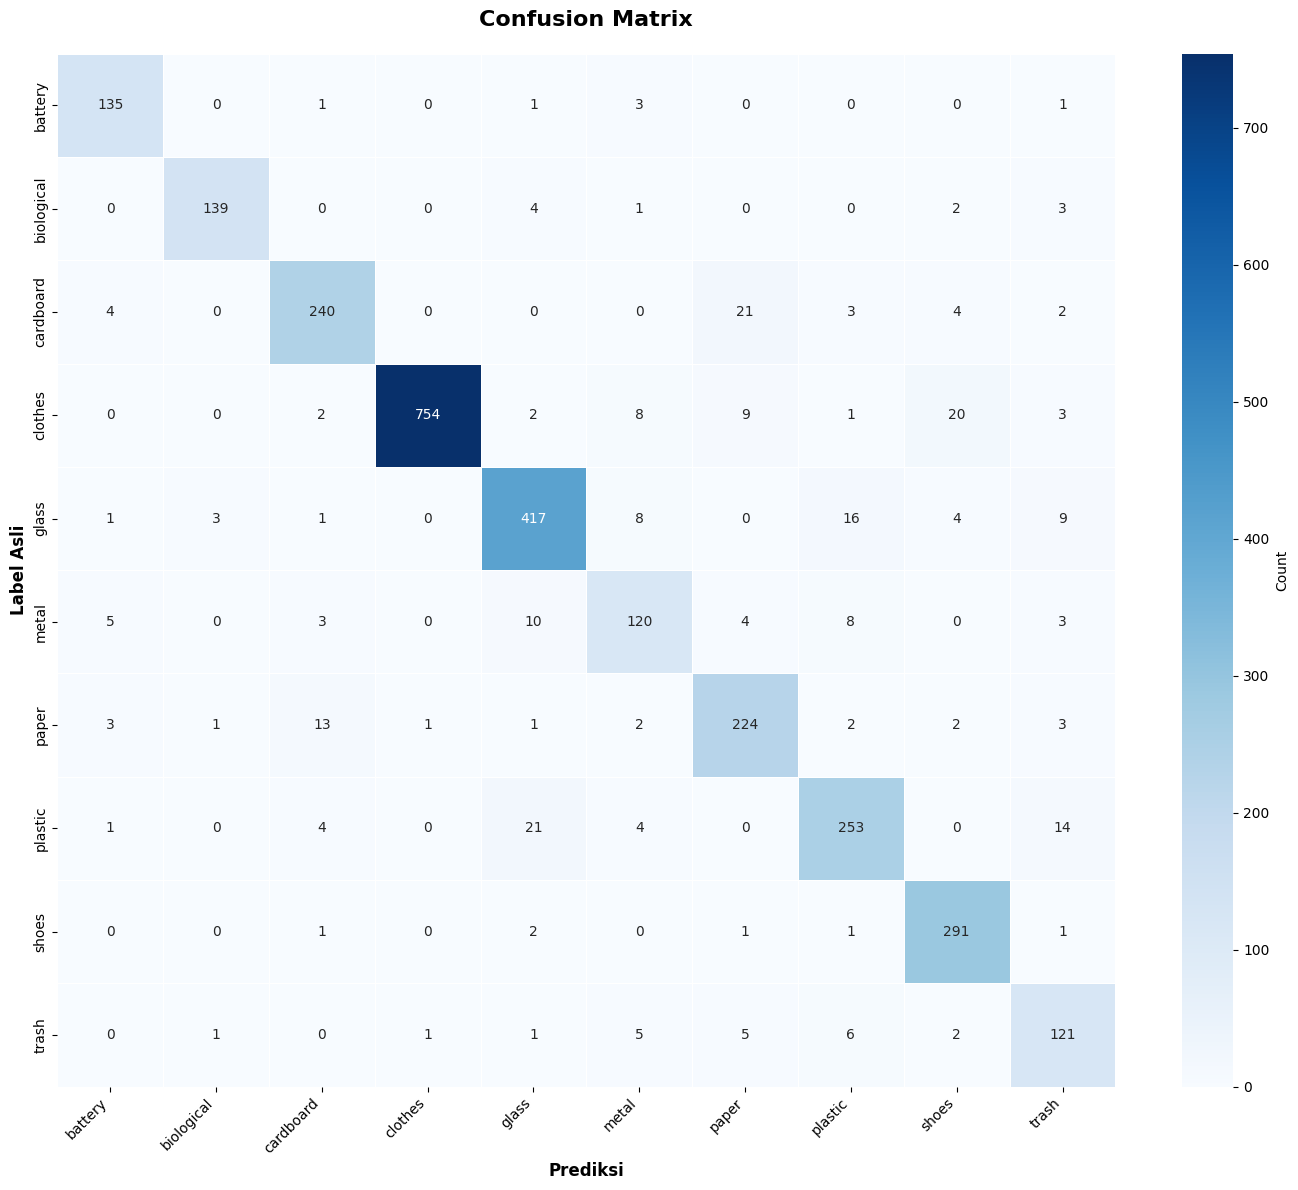

In [17]:
# Generate confusion matrix
y_pred = []
y_true = []

for batch_images, batch_labels in test_dataset:
    predictions = model.predict(batch_images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediksi', fontsize=12, fontweight='bold')
plt.ylabel('Label Asli', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Konversi Model

In [18]:
# Konversi model ke berbagai format
#  SavedModel format
KERAS_MODEL = os.path.join(BASE_DIR, 'saved_model/best_model.keras')
model = tf.keras.models.load_model(KERAS_MODEL)
model.export(MODEL_DIR)
print(f" SavedModel tersimpan di: {MODEL_DIR}")

#  TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan TFLite model
tflite_model_path = os.path.join(TFLITE_DIR, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f" TFLite model tersimpan di: {tflite_model_path}")

# Simpan labels
labels_path = os.path.join(TFLITE_DIR, 'labels.txt')
with open(labels_path, 'w') as f:
    for class_name in CLASS_NAMES:
        f.write(f"{class_name}\n")
print(f" Labels tersimpan di: {labels_path}")


INFO:tensorflow:Assets written to: d:\Dicoding\Deep learning\Garbage classification\saved_model\assets


INFO:tensorflow:Assets written to: d:\Dicoding\Deep learning\Garbage classification\saved_model\assets


Saved artifact at 'd:\Dicoding\Deep learning\Garbage classification\saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1678010081616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009772624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009761872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009775504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009764944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009769552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009770704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009771088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009767056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1678009773008: TensorSpec(shape=(), dtype=tf.resource, nam

In [ ]:
import tensorflowjs as tfjs
import shutil

# Convert SavedModel ke TFJS
tfjs.converters.convert_tf_saved_model(
    MODEL_DIR,
    TFJS_DIR
)

# Verify hasil
tfjs_files = os.listdir(TFJS_DIR)
json_files = [f for f in tfjs_files if f.endswith('.json')]
bin_files = [f for f in tfjs_files if f.endswith('.bin')]

## Inference (Optional)

In [20]:
# Load model dan test inference
import numpy as np
from PIL import Image

model = tf.keras.models.load_model('saved_model/best_model.keras')
sample_image_path = 'garbage-dataset\clothes\clothes_2.jpg'
img = Image.open(sample_image_path).resize((224, 224))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
predictions = model.predict(img_array)
predicted_class = CLASS_NAMES[np.argmax(predictions)]
confidence = np.max(predictions) * 100

print(f"Predicted: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 [==============================] - 1s 753ms/step
Predicted: clothes
Confidence: 100.00%
